# CNN for Training RADIOML 2018 Dataset

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import seed
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Add, Input, Flatten

### Import Preprocessed Data

In [2]:
def import_data(classes, path=None):
    ''' Function imports preprocessed data and labels
    
    Args:
        Classes: ordered list of classes
        path: path for input files
        
    Returns:
        Dataset and labels for inputting into tensorflow model
        
    Raises:
        None
    
    '''
    data = []
    labels = []
    
    if path == None:
        path = '../Data/RFML_Data/RS_1024/'
        width = 1024
        ext = '_1024_'
    
    elif path == 1:
        path = '../Data/RFML_Data/RS_128/'
        width = 128
        ext = '_128_'
    
    for cls in classes:
        temp_D_path = path + cls + ext + 'D.npy'
        temp_L_path = path + cls + ext + 'L.npy'
        
        d = np.load(temp_D_path)
        l = np.load(temp_L_path)
        
        l = np.delete(l, slice(len(classes), 24), 1)
        data.append(d)
        labels.append(l)

    data = np.reshape(data, (len(classes) * 106496, 2, width, 1))
    labels = np.reshape(labels, (len(classes) * 106496, len(classes)))

    return data, labels

In [3]:
classes = ['32PSK',
            '16APSK',
            '32QAM',
            'FM',
            'GMSK',
            '32APSK',
            'OQPSK',
            '8ASK',
            'BPSK',
            '8PSK',
            'AM-SSB-SC',
            '4ASK',
            '16PSK',
            '64APSK',
            '128QAM',
            '128APSK',
            'AM-DSB-SC',
            'AM-SSB-WC',
            '64QAM',
            'QPSK',
            '256QAM',
            'AM-DSB-WC',
            'OOK',
            '16QAM']

labels = 5
X, y = import_data(classes[:labels], path=None)

print('Input Shape: ',X.shape, '\t', 'Output Shape: ', y.shape)

Input Shape:  (532480, 2, 1024, 1) 	 Output Shape:  (532480, 5)


### Develop and Train Model

In [4]:
def cnn2d(input_dim, labels):
    ''' Function develops 2D CNN model
    
    Args:
        input_dim: Dimensions of input data (2, 1024, 1)
        labels: int for number of target labels
        
    Returns:
        Model for training
        
    Raises:
        None
    '''
    
    kern_size = (3, 3)
    pool_sz = (2, 2)
    
    x_input = Input(shape=input_dim)
        
    x = Conv2D(32, kern_size, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=pool_sz, padding='same')(x)
    
    x = Conv2D(32, kern_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=pool_sz, padding='same')(x)
    
    x = Conv2D(32, kern_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=pool_sz, padding='same')(x)
    
    x = Conv2D(64, kern_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=pool_sz, padding='same')(x)
    
    x = Conv2D(64, kern_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=pool_sz, padding='same')(x)
    
    x = Conv2D(64, kern_size, padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    output = Dense(labels, activation='softmax')(x)
    
    model = tf.keras.models.Model(x_input, output)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [5]:
def train_mod(model, x_train, y_train, x_test=None, y_test=None, epochs=10):
    ''' Function fits and trains model
    
    Args:
        model: Compiled model to be trained
        x_train: input data for training
        y_train: target data for training
        x_test: input data for testing
        y_test: target data for testing
        epochs: epochs for training
        
    Returns:
        Tensorflow data containing training results
        
    Raises:
        None
    '''
    
    if all(v is None for v in [x_test, y_test]):
        data = model.fit(x_train, y_train, epochs=epochs)
        
    else:
        data = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs)
    
    return data

In [6]:
# Split data into training and evaluation
seed(14)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [7]:
model = cnn2d((2, x_train.shape[-2], 1), labels)

[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]

(None, 2, 1024, 1) <dtype: 'float32'>
(None, 5) <dtype: 'float32'>


[None]

In [8]:
data = train_mod(model, x_train, y_train, x_test, y_test, 5)

Epoch 1/5
12480/12480 [==============================] - 352s 28ms/step - loss: 0.6171 - accuracy: 0.7074 - val_loss: 0.5800 - val_accuracy: 0.7370
Epoch 2/5
12480/12480 [==============================] - 354s 28ms/step - loss: 0.5496 - accuracy: 0.7386 - val_loss: 0.5434 - val_accuracy: 0.7374
Epoch 3/5
12480/12480 [==============================] - 355s 28ms/step - loss: 0.5365 - accuracy: 0.7450 - val_loss: 0.5325 - val_accuracy: 0.7455
Epoch 4/5
12480/12480 [==============================] - 355s 28ms/step - loss: 0.5289 - accuracy: 0.7493 - val_loss: 0.5214 - val_accuracy: 0.7524
Epoch 5/5
12480/12480 [==============================] - 357s 29ms/step - loss: 0.5225 - accuracy: 0.7525 - val_loss: 0.5095 - val_accuracy: 0.7569


### Evaluate Results

In [9]:
def plot_results(results):
    ''' Function plots results from model training
    
    Args:
        results: output data from model.fit funtion
        
    Returns:
        None
        
    Raises:
        None
        
    '''
    
    loss = results.history.get('loss')
    acc = results.history.get('accuracy')
    val_loss = results.history.get('val_loss')
    val_acc = results.history.get('val_accuracy')
    
    fig, axs = plt.subplots(2,1, figsize=(16,12))
    plt.sca(axs[0])
    plt.plot(range(len(loss)), loss, color='r', label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, color='b',label='Validation Loss')
    plt.legend()
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    plt.grid()

    plt.sca(axs[1])
    plt.plot(range(len(acc)), acc, color='r', label = 'Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, color='b', label='Validation Accuracy')
    plt.legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.grid()

    plt.show()
    
    return None

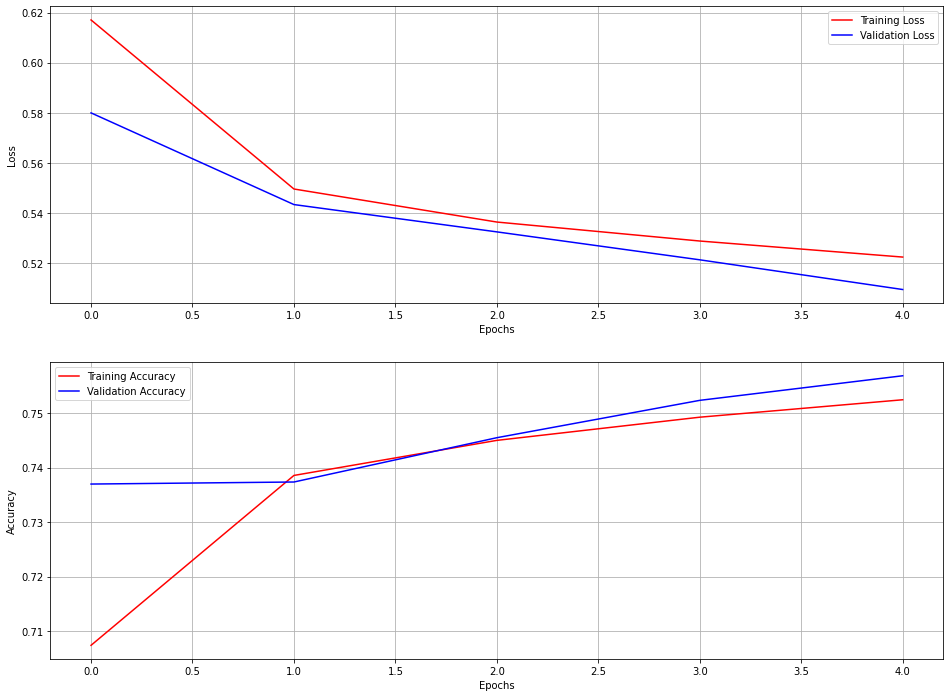

In [10]:
plot_results(data)

Accuracy tapers. Adjustments to model are necessary to improve results.

In [11]:
tf.keras.backend.clear_session()